<a href="https://colab.research.google.com/github/hector6298/Deep-Learning-Collab-notebooks/blob/master/1D_inception_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Inception 1D

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, MaxPool1D, Concatenate, BatchNormalization, AveragePooling1D, Input, LSTM, Flatten, Add
from tensorflow.keras import activations, Model

import matplotlib.pyplot as plt
import numpy as np

In [48]:
class Conv1D_bn(Layer):
  def __init__(self, 
               filters, 
               kernel_size, 
               strides, 
               padding='causal', 
               activation='relu', 
               use_bias=False,
               name=None):
    super().__init__()
    self.conv = Conv1D(filters=filters,  
                        kernel_size=kernel_size,
                        strides=strides,
                        activation=activation,
                        padding=padding,
                       use_bias=use_bias,
                       name=name)
    self.batchNormalization = BatchNormalization()
    self.activation = activations.get(activation)
  
  def call(self, inputs):
    x = self.conv(inputs)
    x = self.batchNormalization(x)
    if self.activation is not None:
      x = self.activation(x)
    return x

In [49]:
class StemModule(Layer):
  def __init__(self, num_filters=32, kernel_sizes=[10,20,40],activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.num_filters = num_filters
    self.kernel_size = kernel_sizes
    self.activation = activations.get(activation)

    self.conv1_1 = Conv1D_bn(filters=self.num_filters,  # 228 --> 114
                        kernel_size=self.kernel_size[0],
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    self.conv1_2 = Conv1D_bn(filters=self.num_filters,
                        kernel_size=self.kernel_size[0],
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    self.conv1_3 = Conv1D_bn(filters=self.num_filters,
                        kernel_size=self.kernel_size[0],
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    self.conv1_4 = Conv1D_bn(filters=self.num_filters,  # 228 --> 114
                        kernel_size=self.kernel_size[0],
                        strides=2,
                        activation=self.activation,
                        padding='causal')
    self.pool1 = MaxPool1D(pool_size=3,strides=2, padding='same') # 114 --> 57
    

    self.conv2_1x1 = Conv1D_bn(filters=self.num_filters*2, # 114 --> 57
                        kernel_size=1,
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    self.conv3 = Conv1D_bn(filters=self.num_filters*2, 
                        kernel_size=self.kernel_size[2],
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    
    self.conv4 = Conv1D_bn(filters=self.num_filters*2,  # 228 --> 114
                        kernel_size=self.kernel_size[0],
                        strides=2,
                        activation=self.activation,
                        padding='causal')
    self.pool2 = MaxPool1D(pool_size=3,strides=2, padding='same')
    

    
  def call(self, inputs):
    x = self.conv1_1(inputs)
    x = self.conv1_2(x)
    x = self.conv1_3(x)

    b1 = self.conv1_4(x)
    b2 = self.pool1(x)
    concat1 = Concatenate()([b1,b2])
    concat1 = self.activation(concat1)

    x = self.conv2_1x1(concat1)
    x = self.conv3(x)

    b1 = self.conv4(x)
    b2 = self.pool2(x)
    concat2 = Concatenate()([b1,b2])
    concat2 = self.activation(concat1)

    return concat2
    

In [50]:
class InceptionModule(Layer):
  def __init__(self, num_filters=32, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.num_filters = num_filters
    self.activation = activations.get(activation)

    self.conv1 = Conv1D_bn(filters=self.num_filters//3, 
                        kernel_size=11,
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    
    self.conv2 = Conv1D_bn(filters=self.num_filters//3, 
                        kernel_size=21,
                        strides=1,
                        activation=self.activation,
                        padding='causal')
  
    #factored convolution
    self.conv3_1 = Conv1D_bn(filters=self.num_filters//3, 
                        kernel_size=21,
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    self.conv3_2 = Conv1D_bn(filters=self.num_filters//3, 
                        kernel_size=11,
                        strides=1,
                        activation=self.activation,
                        padding='causal')
    self.conv3_3 = Conv1D_bn(filters=self.num_filters//3, 
                        kernel_size=11,
                        strides=1,
                        activation=self.activation,
                        padding='causal')
   
    #self.pool = AveragePooling1D(pool_size=3,strides=1, padding='same')
    self.bottleneck = Conv1D_bn(filters=self.num_filters, strides=1, kernel_size=1, use_bias=False, padding='causal')

  def call(self,inputs):
    x = self.bottleneck(inputs)
    #x_pool = self.pool(inputs)
    c1 = self.conv1(x)
    c2 = self.conv2(x)
    c3_1 = self.conv3_1(x)
    c3_2 = self.conv3_2(c3_1)
    c3_3 = self.conv3_3(c3_2)
    #c4 = self.bottleneck(x_pool)
    concat = Concatenate()([c1,c2,c3_3])
    return self.activation(concat)


In [51]:
class reductionModule(Layer):
  def __init__(self, num_filters, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.num_filters = num_filters
    self.activation = activations.get(activation)

    self.bottleneck = Conv1D_bn(filters=self.num_filters, strides=1, kernel_size=1, use_bias=False, activation=activation, padding='causal')
    self.pool = MaxPool1D(pool_size=3, strides=2, padding='same')

    self.conv1 = Conv1D_bn(filters=self.num_filters//2, kernel_size=11, strides=2, activation=activation, padding='causal')
    self.conv2 = Conv1D_bn(filters=self.num_filters//2, kernel_size=21, strides=2, activation=activation, padding='causal')
  
  def call(self, inputs):
    x = self.bottleneck(inputs)
  
    x_pool = self.pool(inputs)
    x1 = self.conv1(x)
    x2 = self.conv2(x)
    concat = Concatenate()([x1,x2,x_pool])
    out = self.activation(concat)
    return out
    


In [52]:
class skip_connection_inception(Layer):
  def __init__(self,out_tensor, activation='relu'):
    super().__init__()
    self.activation = activations.get(activation)
    self.bn = BatchNormalization()
    self.conv = Conv1D_bn(filters=int(out_tensor.shape[-1]), 
                         kernel_size=1, 
                         strides=1,
                         padding='causal',
                         use_bias=False)
  def call(self, input_tensor, out_tensor):
    shortcut = self.conv(input_tensor)
    shortcut = self.bn(shortcut)
    out = Add()([shortcut, out_tensor])
    return self.activation(out)


In [53]:
class skip_connection_stem(Layer):
  def __init(self,activation='relu', equal_filters=True):
    super().__init__()
    self.activation = activations.get(activation)
    self.equal_fitlers = equal_filters
  def call(self, input_tensor, out_tensor):
    
    if self.equal_filters:
      input_tensor = Conv1D_bn(filters=int(out_tensor.shape[-1]), 
                          kernel_size=1, 
                          padding='causal', 
                          use_bias=False)(input_tensor)
    shortcut = MaxPooling1D(pool_size=3,
                            strides=2,
                            padding='same')(input_tensor)
    shortcut = batchNormalization()(shortcut)
    out = Add()([shortcut, out_tensor])
    return self.activation(out)

In [65]:
def construct_timeception(input_shape):

  ############################# INPUT ########################
  inputs = Input(shape=input_shape)
  ######################## STEM ##############################
  stem = StemModule(num_filters=8,
                    activation='swish')(inputs)
  ######################## BLOCK 1 ###########################
  inceptionb1_1 = InceptionModule(num_filters=stem.shape[-1],
                               activation='swish')(stem)
  inceptionb1_2 = InceptionModule(num_filters=stem.shape[-1],
                               activation='swish')(inceptionb1_1)
  inceptionb1_3 = InceptionModule(num_filters=stem.shape[-1],
                               activation='swish')(inceptionb1_2)
  residual1 = skip_connection_inception(inceptionb1_3, activation='swish')(stem,inceptionb1_3)

  reduction1 = reductionModule(num_filters=residual1.shape[-1],
                               activation='swish')(residual1)
  #rnn1 = LSTM(reduction1.shape[-1], return_sequences=True)(reduction1)
  ######################## BLOCK 2 ###########################
  inceptionb2_1 = InceptionModule(num_filters=reduction1.shape[-1],
                               activation='swish')(reduction1)
  inceptionb2_2 = InceptionModule(num_filters=reduction1.shape[-1],
                               activation='swish')(inceptionb2_1)
  inceptionb2_3 = InceptionModule(num_filters=reduction1.shape[-1],
                               activation='swish')(inceptionb2_2)
  residual2 = skip_connection_inception(inceptionb2_3, activation='swish')(reduction1,inceptionb2_3)

  reduction2 = reductionModule(num_filters=residual2.shape[-1],
                               activation='swish')(residual2)
  #rnn2 = LSTM(reduction2.shape[-1], return_sequences=True)(reduction2)
  ######################## BLOCK 3 ###########################
  inceptionb3_1 = InceptionModule(num_filters=reduction1.shape[-1],
                               activation='swish')(reduction2)
  inceptionb3_2 = InceptionModule(num_filters=reduction2.shape[-1],
                               activation='swish')(inceptionb3_1)
  inceptionb3_3 = InceptionModule(num_filters=reduction2.shape[-1],
                               activation='swish')(inceptionb3_2)
  residual3 = skip_connection_inception(inceptionb3_3, activation='swish')(reduction2,inceptionb3_3)

  reduction3 = reductionModule(num_filters=residual3.shape[-1],
                               activation='swish')(residual3)
  
  rnn3 = LSTM(10, return_sequences=True)(reduction3)
  out = LSTM(1, return_sequences=False)(rnn3)
  
  return Model(inputs=inputs, outputs=out)
  
  

In [66]:
model = construct_timeception(input_shape=(224,1))
model.compile(optimizer='adam', loss='mse')

In [70]:
def train_function(x):
    return np.sin(x)
def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
                end_ix = i + n_steps
                if end_ix > len(sequence)-1:
                        break
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                X.append(seq_x)
                y.append(seq_y)
        return np.array(X), np.array(y)
# define input sequence
xaxis = np.arange(-50*np.pi, 50*np.pi, 0.1)
train_seq = train_function(xaxis)
n_steps = 224
X, y = split_sequence(train_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print("X.shape = {}".format(X.shape))
print("y.shape = {}".format(y.shape))

X.shape = (2918, 224, 1)
y.shape = (2918,)


In [71]:
history = model.fit(X, y, epochs=20, verbose=1)
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

Epoch 1/20
92/92 [==============================] - 34s 367ms/step - loss: 0.0012
Epoch 2/20
92/92 [==============================] - 36s 394ms/step - loss: 0.0058
Epoch 3/20
92/92 [==============================] - 35s 384ms/step - loss: 0.0247
Epoch 4/20
92/92 [==============================] - 34s 374ms/step - loss: 0.0046
Epoch 5/20
92/92 [==============================] - 35s 379ms/step - loss: 0.0028
Epoch 6/20
92/92 [==============================] - 38s 413ms/step - loss: 0.0013
Epoch 7/20
10/92 [==>...........................] - ETA: 27s - loss: 0.0010

KeyboardInterrupt: ignored

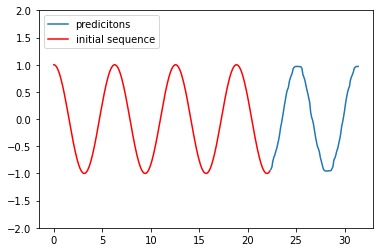

In [73]:
test_xaxis = np.arange(0, 10*np.pi, 0.1)
def test_function(x):
    return np.cos(x)
calc_y = test_function(test_xaxis)
# start with initial n values, rest will be predicted
test_y = calc_y[:n_steps]
results = []
for i in range( len(test_xaxis) - n_steps ):
    net_input = test_y[i : i + n_steps]
    net_input = net_input.reshape((1, n_steps, n_features))
    y = model.predict(net_input, verbose=0)
    test_y = np.append(test_y, y)
plt.plot(test_xaxis[n_steps:], test_y[n_steps:], label="predicitons")
#plt.plot(test_xaxis, calc_y, label="ground truth")
plt.plot(test_xaxis[:n_steps], test_y[:n_steps], label="initial sequence", color="red")
plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()